# The

In [1]:
import numpy as np

from parse_AiThinker_data import read_file_data, get_array_from_df, calc_results

In [55]:
import statistics


def median_function(x, n_measured):
    if len(x) <= n_measured:
        return x[-1]
    len_ = len(x) - 1
    return statistics.median(x[(len_ - n_measured):-1])


def filtering_function(x, n_measured):
    if len(x) <= n_measured:
        return x[-1]
    len_ = len(x) - 1
    return np.mean(x[(len_ - n_measured):-1])

In [48]:
# KALMAN FILTER
def calc_kalman(e0, x0, k0, z, sigma_psi, sigma_eta, acc=None, v=None, model_func=None, params=None,
                time: np.ndarray = None):
    """
    Function calculates the traveled distance using Kalman filter
        # :param conn_func - the noiseless connection between the state vector and the measurement vector, and is assumed stationary over time
        :param e0 - initial error of sensor
        :param x0 - initial state
        :param k0 - initial Kalman gain
        :param z - sensors data
        :param time - time array
        :param sigma_psi - model deviation
        :param sigma_eta - sensor deviation
        The model should specify acceleration and/or velocity to use Kalman filter
        :param acc - acceleration
        :param v - velocity"""

    if time is not None:
        dt = np.abs(time[1] - time[0])

    # number of measured acceleration components
    n = e0.shape[0]
    use_function = False
    if acc is not None:
        if isinstance(v, float):
            v = np.array([acc[i] * dt + v] for i in np.arange(n))
        elif v is None:
            if model_func is None:
                v = np.multiply(acc, dt)
            else:
                use_function = True
    else:
        if isinstance(v, float):
            v = np.array([acc[i] * dt + v] for i in np.arange(n))
        elif v is None:
            if model_func is None:
                v = np.multiply(acc, dt)
            else:
                use_function = True
    # number of frames
    # k = time.shape[0]

    # x_opt = np.zeros(k, )
    # e_opt = np.zeros(k, )
    x_opt = []

    x_opt.append(z[0])
    e_opt_prev = e0

    # Kalman gain
    K = np.zeros(z.shape[0])

    K_current = [k0]

    for i in np.arange(0, len(z)):
        e_opt = np.sqrt(
            (sigma_eta ** 2) * (e_opt_prev ** 2 + sigma_psi ** 2)
            /
            (sigma_eta ** 2 + e_opt_prev ** 2 + sigma_psi ** 2)
        )
        K[i] = (e_opt) ** 2 / (sigma_eta ** 2)
        K_current = (e_opt) ** 2 / (sigma_eta ** 2)

        # add the traveled distance in both x and y
        if use_function is False:
            x_opt.append(
                (x_opt[i - 1] + np.sqrt(np.sum([(v[i - 1] * dt) ** 2]))) * (1 - K_current) + (K_current * z[i]))
        else:
            x_opt.append((model_func(x_opt, params)) * (1 - K_current) + (K_current * z[i]))
        e_opt_prev = e_opt
    return x_opt, e_opt_prev, K, x_opt[-1]

In [4]:
path = "data_for_kalman_filter/Receive_20230406172141.txt"
df_of_results = read_file_data(path, min_num_of_measurements=40)
results = get_array_from_df(df_of_results)
array_of_results = df_of_results.to_numpy()


In [13]:
from numpy.random._examples.cffi.extending import rng


def make_noize(y, deviation) -> float:
    return y + rng.normal(scale=deviation, size=y.size)

In [20]:
first_anchor_data = results[0][0]
second_anchor_data = results[0][1]

In [33]:
noizy_first = make_noize(first_anchor_data, 0.6)

In [79]:
e0 = np.array([0])
x0 = 0

k0 = 0.5
sigma_psi = 0.19
sigma_eta = 0.19

result_1, _, _, _ = calc_kalman(e0=e0, x0=x0, k0=k0, z=first_anchor_data, sigma_psi=sigma_psi, sigma_eta=sigma_eta,
                                model_func=median_function, params=10)

In [80]:
result_noizy_1, _, K, _ = calc_kalman(e0=e0, x0=x0, k0=k0, z=noizy_first, sigma_psi=sigma_psi, sigma_eta=sigma_eta,
                                      model_func=median_function, params=10)


In [81]:
e0 = np.array([0])
x0 = 0

k0 = 0.5
sigma_psi = 0.19
sigma_eta = 0.19

result_2, _, _, _ = calc_kalman(e0=e0, x0=x0, k0=k0, z=second_anchor_data, sigma_psi=sigma_psi, sigma_eta=sigma_eta,
                                model_func=filtering_function, params=3)

In [82]:
i = 0
median = []
while i < noizy_first.shape[0]:
    median.append(statistics.median((noizy_first[i:i+5])))
    i += 1

# median = [statistics.median((noizy_first[i-5:i]) for i in np.arange(5, noizy_first.shape[0], 5))]

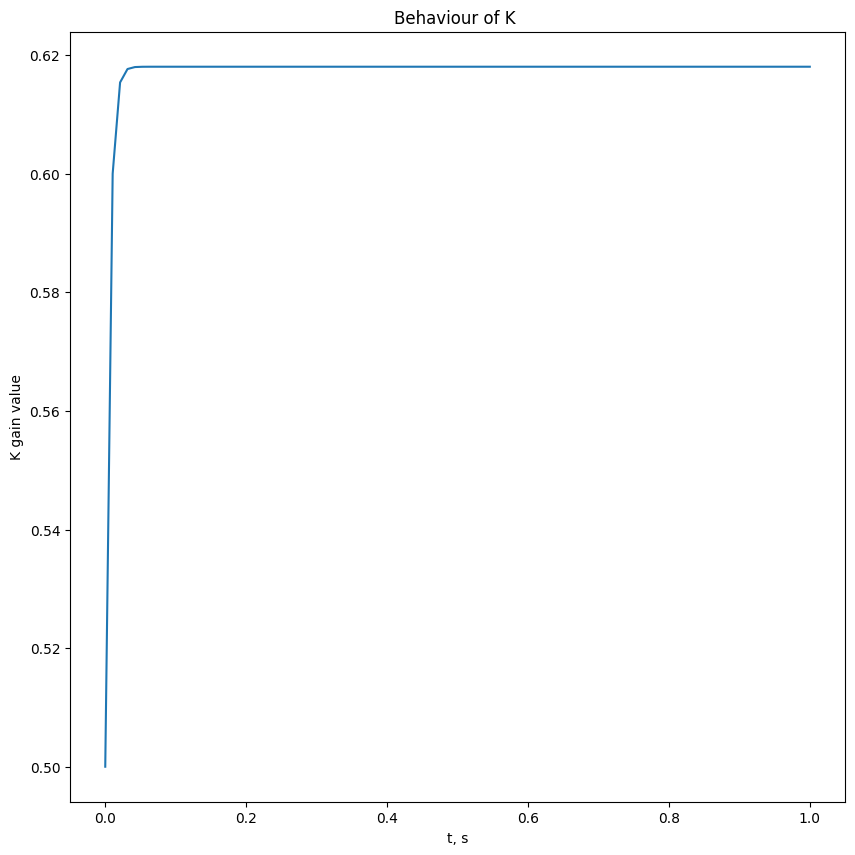

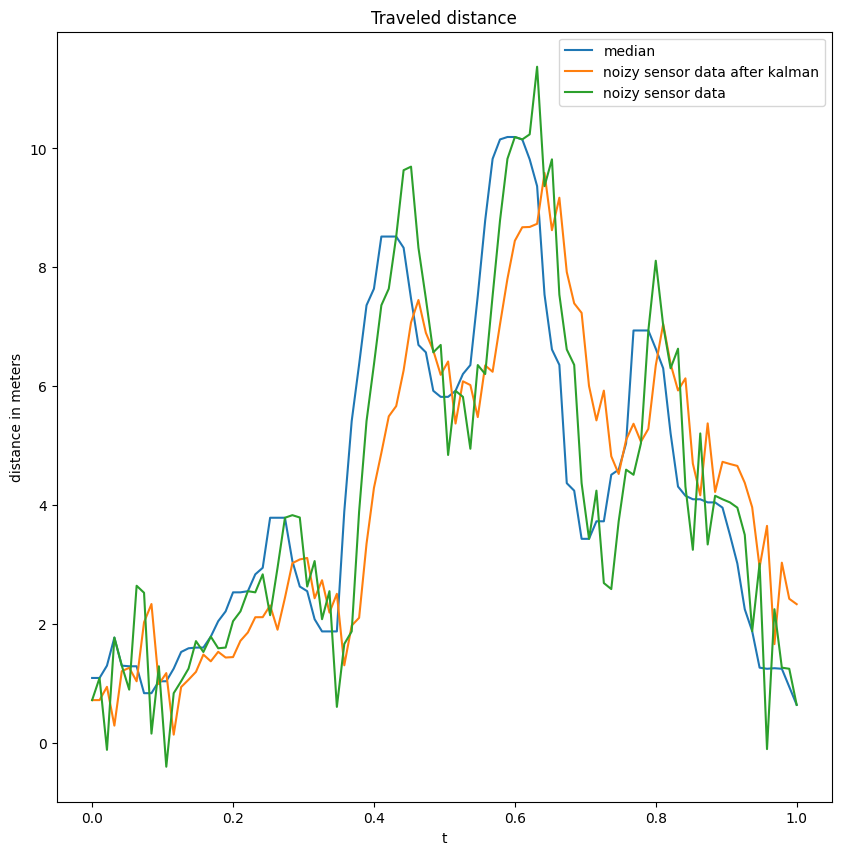

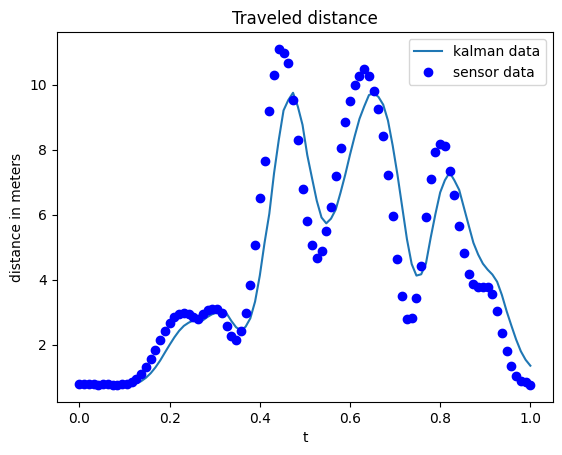

In [83]:
import matplotlib.pyplot as plt

# print(f"Resulting Kalman gain value: {Ks[-1]}")
# print(f"Mean Square Error: {mean_squared_error(result, first_anchor_data)} m")
time = np.linspace(0, 1, first_anchor_data.shape[0])
time_for_median = np.linspace(0, 1, int(first_anchor_data.shape[0]/5)+1)
fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(time, K)
plt.title(f"Behaviour of K ")
plt.xlabel("t, s")
plt.ylabel("K gain value")
plt.show()

fig, ax = plt.subplots(figsize=(10, 10))

# plt.plot(t, y_model, label='model')
plt.plot(time, median, label='median')
# plt.plot(time, result_1[:-1], label='pure sensor data after kalman')
# plt.plot(time, first_anchor_data, label='pure sensor data')
plt.plot(time, result_noizy_1[:-1], label='noizy sensor data after kalman')
plt.plot(time, noizy_first, label='noizy sensor data')

plt.xlabel('t')
plt.ylabel('distance in meters')
plt.legend()
plt.title("Traveled distance")
plt.show()

plt.plot(time, result_2[:-1], label='kalman data')
plt.plot(time, second_anchor_data, 'bo', label='sensor data')

plt.xlabel('t')
plt.ylabel('distance in meters')
plt.legend()
plt.title("Traveled distance")
plt.show()

In [10]:
xy_values = []
n_values = 10
e0 = np.array([0, 0])
k = 0.5
sigma_psi = np.array([0.19, 0.19])
sigma_eta = np.array([0.19, 0.19])

for x, y in zip(first_anchor_data, second_anchor_data):
    if len(xy_values) < n_values:
        xy_values.append(np.array([x, y]))
    else:
        _, e0, k, xy_new = calc_kalman(e0=e0, x0=xy_values[-1], k0=k, z=np.array([x, y]), sigma_psi=sigma_psi,
                                       sigma_eta=sigma_eta, model_func=filtering_function, params=n_values)
        xy_values.append([xy_new[0], xy_new[1]])
        xy_values.
xy_values = np.array(xy_values)

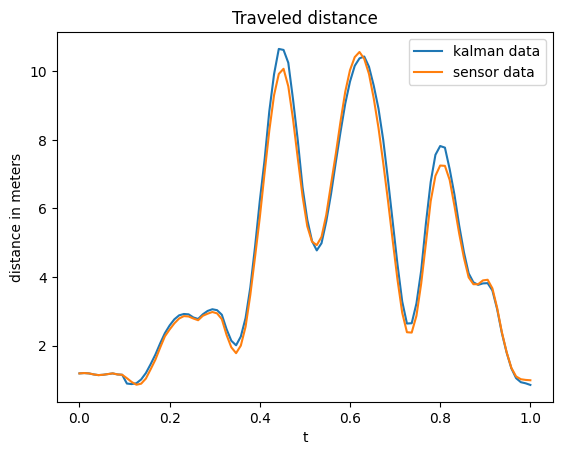

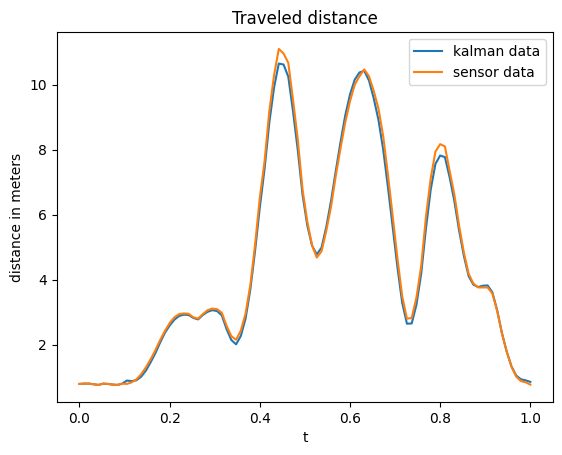

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# print(f"Resulting Kalman gain value: {Ks[-1]}")
# print(f"Mean Square Error: {mean_squared_error(result, first_anchor_data)} m")
time = np.linspace(0, 1, first_anchor_data.shape[0])
# plt.plot(t, y_model, label='model')
plt.plot(time, xy_values[:, 0], label='kalman data')
plt.plot(time, first_anchor_data, label='sensor data')

plt.xlabel('t')
plt.ylabel('distance in meters')
plt.legend()
plt.title("Traveled distance")
plt.show()

plt.plot(time, xy_values[:, 1], label='kalman data')
plt.plot(time, second_anchor_data, label='sensor data')

plt.xlabel('t')
plt.ylabel('distance in meters')
plt.legend()
plt.title("Traveled distance")
plt.show()